## Bibliotecas

In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

import urllib.request, json
import numpy as np


In [39]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Dados

In [40]:
res = urllib.request.urlopen("http://127.0.0.1:8000/api/vagas/")
data = json.loads(res.read())
vagas = data['data']

## Tratamento dos dados

In [41]:
max_sequence=0

words = []
y = []

for vaga in vagas:
    words.append(vaga['tokens'])
    y = y + [int(vaga['isApplied'])]

char_set = ['<pad>'] 

w = set()
for tokenList in words:
    for token in tokenList:
        w.add(token)
char_set += list(w)
char_set += ['<_unknown>']
char2idx = {char:idx for idx, char in enumerate(char_set)}

json_str = json.dumps(char2idx, ensure_ascii=False)
json_str = json.loads(json_str)
with open('char2idx.json', 'w', encoding='utf-8') as json_file:
    json.dump(json_str, json_file, ensure_ascii=False)

X = list(map(lambda word: [char2idx.get(char) for char in word], words))
max_sequence = max(list(map(lambda word: len(word), X)))
X = pad_sequences(X, maxlen=max_sequence, padding='post', truncating='post')

## Modelo

In [42]:
buffer_size = len(vagas)
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=buffer_size).batch(batch_size=batch_size)


input_dim = len(char2idx)
output_dim = len(char2idx)


model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, trainable=False, embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10),
    Dense(2)
])

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 801)         641601    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10)                8120      
                                                                 
 dense_4 (Dense)             (None, 2)                 22        
                                                                 
Total params: 649743 (2.48 MB)
Trainable params: 8142 (31.80 KB)
Non-trainable params: 641601 (2.45 MB)
_________________________________________________________________


## Treinamento

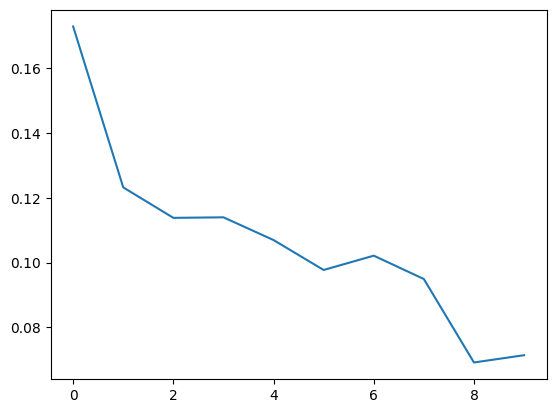

In [43]:
def loss_fn(model, X, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true=y, 
                                                                          y_pred=model(X), 
                                                                          from_logits=True))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
epoch = 10
tr_loss_hist = []

for e in range(epoch):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb)
            
        grads = tape.gradient(tr_loss, sources=model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
plt.figure()
plt.plot(tr_loss_hist)
plt.show()

## Inferencia

In [49]:
exemple = [
    ["analista", "desenvolvedor", "remoto"]
]

UNKNOWN_IDX = (len(char_set) - 1)
novoX = list(map(lambda word: [char2idx.get(char) or UNKNOWN_IDX for char in word], exemple))
novoX = pad_sequences(novoX, maxlen=max_sequence, padding='post', truncating='post')
y_pred = model.predict(novoX)
print(y_pred)
print('acc: {:.2%}'.format(np.mean(y_pred)))


1/1 [==============================] - 0s 29ms/step
[[ 1.5235343 -1.7540929]]
acc: -11.53%
